In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
random.seed(12345)
np.random.seed(12345)

In [2]:
DELTA = 0.95
num_episodes = 10000000
alpha = 0.15
eps = 1e-5
actions_space = np.arange(1.43, 2.0, 0.04)
# actions_space = np.linspace(1.0, 2.5, 20)
n_actions = actions_space.size
n_agents = 2

In [3]:
n_actions

15

In [4]:
quality = np.ones(n_agents) * 2
margin_cost = np.ones(n_agents)
# margin_cost[1] = 0.5
horizon = 1/4
a0 = 0
def reward_comp(action):
    # Compute profits for all agents
    price = actions_space[action]
    demand = np.exp((quality - price) / horizon)
    demand = demand / (np.sum(demand) + np.exp(a0 / horizon))
    reward = np.multiply(price - margin_cost, demand)
    return reward

In [5]:
# for i in range(n_actions):
#     print(reward_comp([0, i]))

In [6]:
reward_sum = np.zeros(n_actions)
for self_act in range(n_actions):
    for rival_act in range(n_actions):
        if rival_act == self_act: 
            continue
        state = np.array([self_act, rival_act])
        reward_sum[self_act] += reward_comp(state)[0]
reward_sum = reward_sum/(1 - DELTA)/np.power(n_actions, n_agents-1)

In [7]:
reward_sum

array([5.58232796, 5.78802889, 5.92606135, 5.99644584, 6.00067233,
       5.94172477, 5.82402394, 5.65328833, 5.43631956, 5.18072579,
       4.89460298, 4.58619785, 4.26357789, 3.93433261, 3.60532586])

In [8]:
# Q = np.zeros((n_agents, n_actions, n_actions, n_actions))
# for agent in range(n_agents):
#     for act in range(n_actions):
#         Q[agent, :, :, act] = reward_sum[act]
# Q[1].argmax(2)[0, 0]

In [9]:
# Q matrix, first two indices as states, last one as actions
Q = np.zeros((n_agents, n_actions, n_actions, n_actions))

# Q = np.ones((n_agents, n_actions, n_actions, n_actions))*10

# # AER
for agent in range(n_agents):
    for act in range(n_actions):
        Q[agent, :, :, act] = reward_sum[act]

# Topmost
# Q = np.zeros((n_agents, n_actions, n_actions, n_actions))
# bias = np.zeros(n_actions)
# bias[-1] = n_actions - 1
# for agent in range(n_agents):
#     for act in range(n_actions):
#         Q[agent, :, :, act] = bias[act]
# Random        
# Q = np.random.rand(n_agents, n_actions, n_actions, n_actions)

steps_done = np.zeros(n_agents)

def select_action(agent, state):
    # state should be like [1, 2]
    global steps_done
    sample = random.random()
    eps_threshold = np.exp(-eps * steps_done[agent])
    steps_done[agent] += 1
    if sample > eps_threshold:
        return Q[agent][state[0]][state[1]].argmax()
    else:
        return np.random.randint(0, n_actions, 1, dtype=int)

state_hist = []
# Initialize the environment and state
state = np.random.randint(0, n_actions, size=n_agents)
state_hist.append(state)
# Counter for variations in heat
count = 0

heat_unique0 = []
heat_freq0 = []
heat_unique1 = []
heat_freq1 = []

for i_episode in range(num_episodes):
    # For each agent, select and perform an action
    action = np.zeros(n_agents, dtype=int)
    
#     if i_episode == num_episodes - 100:
#         action[0] = 4
#         action[1] = select_action(1, state)
#     else:
    for i in range(n_agents):
        action[i] = select_action(i, state)
        
    reward = reward_comp(action)

    # Move to the next state
    next_state = action
    
    old_heat0 = Q[0].argmax(2)
    old_heat1 = Q[1].argmax(2)
    
    for i in range(n_agents):
        Q[i][state[0]][state[1]][action[i]] = (1-alpha)*Q[i][state[0]][state[1]][action[i]] + \
            alpha*(reward[i] + DELTA*Q[i][next_state[0]][next_state[1]].max())  
    
    new_heat0 = Q[0].argmax(2)  
    new_heat1 = Q[1].argmax(2)
            
    if np.sum(np.abs(old_heat0 - new_heat0)) == 0 and np.sum(np.abs(old_heat1 - new_heat1)) == 0:
        count += 1
    else:
        count = 0
            
    if i_episode%40000 == 0:
#         print('state', state)
        print('price', actions_space[action])
        print('count', count)
    
    if i_episode%5000 == 0:
        uniq0, freq0 = np.unique(new_heat0, return_counts=True)
        heat_unique0.append(uniq0)
        heat_freq0.append(freq0)

        uniq1, freq1 = np.unique(new_heat1, return_counts=True)
        heat_unique1.append(uniq1)
        heat_freq1.append(freq1)

    state = next_state
    state_hist.append(state)
    
    if count == 150000:
        print('Terminate condition satisfied.')
        print('state', state_hist[-20:])
        break

price [1.95 1.47]
count 1
price [1.75 1.95]
count 2
price [1.59 1.95]
count 2
price [1.51 1.55]
count 0
price [1.63 1.79]
count 2
price [1.55 1.59]
count 5
price [1.43 1.71]
count 0
price [1.51 1.55]
count 0
price [1.47 1.47]
count 3
price [1.47 1.99]
count 0
price [1.47 1.47]
count 1
price [1.75 1.83]
count 38
price [1.79 1.71]
count 128
price [1.71 1.71]
count 446
price [1.75 1.59]
count 124
price [1.79 1.71]
count 27
price [1.75 1.59]
count 5436
price [1.75 1.59]
count 944
price [1.79 1.71]
count 7904
price [1.79 1.71]
count 217
price [1.75 1.83]
count 3862
price [1.91 1.83]
count 2404
price [1.71 1.71]
count 11991
price [1.91 1.83]
count 10515
price [1.71 1.83]
count 2742
price [1.71 1.83]
count 8834
price [1.71 1.71]
count 25107
price [1.91 1.83]
count 65107
price [1.71 1.83]
count 105107
price [1.71 1.71]
count 24206
price [1.91 1.83]
count 18287
price [1.71 1.83]
count 58287
price [1.91 1.83]
count 6741
price [1.71 1.83]
count 46741
price [1.71 1.71]
count 86741
price [1.91 1.83

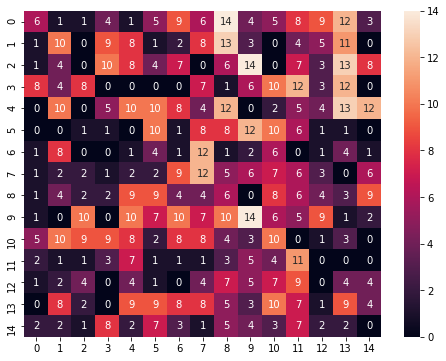

In [10]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(new_heat0, annot=True)
plt.show()

In [11]:
i_episode

1423259

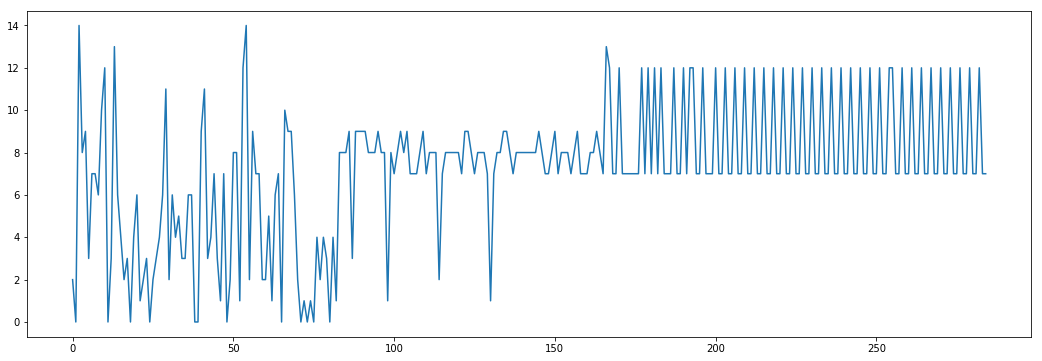

In [12]:
hist = np.array(state_hist)
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(hist[::5000, 0])

In [13]:
cor_hist0 = []
randcor_hist0 = []
sam_size = 128
mem_size = 2000
for i in range(mem_size, mem_size + 30000):
    cor_hist0.append(np.corrcoef(hist[i-sam_size-1:i-1, 0], hist[i-sam_size:i, 0])[1, 0])
    sam_ind1 = np.random.randint(i-mem_size, i, size=sam_size)
    sam_ind2 = np.random.randint(i-mem_size, i, size=sam_size)
    randcor_hist0.append(np.corrcoef(hist[sam_ind1, 0], hist[sam_ind2, 0])[1, 0])
cor_hist0 = np.array(cor_hist0)
randcor_hist0 = np.array(randcor_hist0)

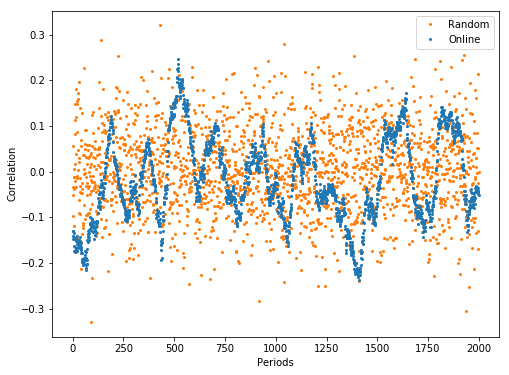

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(randcor_hist0[20000:22000], 'o', markersize=2, color='tab:orange', label='Random')
ax.plot(cor_hist0[20000:22000], 'o', markersize=2, color='tab:blue', label='Online')
ax.set_ylabel('Correlation')
ax.set_xlabel('Periods')
ax.legend(loc='best')
plt.savefig('classic_corr.eps', format='eps', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()